**`widgets.Dropdown` — выпадающий список**

In [2]:
import ipywidgets as widgets
from IPython.display import display

dropdown = widgets.Dropdown(
    options=['Москва', 'Санкт-Петербург', 'Новосибирск'],
    value='Москва',
    description='Город:',
    disabled=False,
)

display(dropdown)


Dropdown(description='Город:', options=('Москва', 'Санкт-Петербург', 'Новосибирск'), value='Москва')

In [3]:
# Пример с options как словарь
dropdown = widgets.Dropdown(
    options={'🇷🇺 Россия': 'RU', '🇺🇸 США': 'US', '🇫🇷 Франция': 'FR'},
    value='RU',
    description='Страна:',
)
display(dropdown)


Dropdown(description='Страна:', options={'🇷🇺 Россия': 'RU', '🇺🇸 США': 'US', '🇫🇷 Франция': 'FR'}, value='RU')

**Реакция на выбор пользователя**

In [4]:
print(widgets.Widget.observe.__doc__)

Setup a handler to be called when a trait changes.

        This is used to setup dynamic notifications of trait changes.

        Parameters
        ----------
        handler : callable
            A callable that is called when a trait changes. Its
            signature should be ``handler(change)``, where ``change`` is a
            dictionary. The change dictionary at least holds a 'type' key.
            * ``type``: the type of notification.
            Other keys may be passed depending on the value of 'type'. In the
            case where type is 'change', we also have the following keys:
            * ``owner`` : the HasTraits instance
            * ``old`` : the old value of the modified trait attribute
            * ``new`` : the new value of the modified trait attribute
            * ``name`` : the name of the modified trait attribute.
        names : list, str, All
            If names is All, the handler will apply to all traits.  If a list
            of str, handler wil

In [5]:
import ipywidgets as widgets
from IPython.display import display

dropdown = widgets.Dropdown(
    options=['Кошка', 'Собака', 'Попугай'],
    value='Кошка',
    description='Питомец:',
)

def on_change(change):
    print(change)

dropdown.observe(on_change)
display(dropdown)


Dropdown(description='Питомец:', options=('Кошка', 'Собака', 'Попугай'), value='Кошка')

{'name': '_property_lock', 'old': traitlets.Undefined, 'new': {'index': 1}, 'owner': Dropdown(description='Питомец:', options=('Кошка', 'Собака', 'Попугай'), value='Кошка'), 'type': 'change'}
{'name': 'label', 'old': 'Кошка', 'new': 'Собака', 'owner': Dropdown(description='Питомец:', index=1, options=('Кошка', 'Собака', 'Попугай'), value='Кошка'), 'type': 'change'}
{'name': 'value', 'old': 'Кошка', 'new': 'Собака', 'owner': Dropdown(description='Питомец:', index=1, options=('Кошка', 'Собака', 'Попугай'), value='Собака'), 'type': 'change'}
{'name': 'index', 'old': 0, 'new': 1, 'owner': Dropdown(description='Питомец:', index=1, options=('Кошка', 'Собака', 'Попугай'), value='Собака'), 'type': 'change'}
{'name': '_property_lock', 'old': {'index': 1}, 'new': {}, 'owner': Dropdown(description='Питомец:', index=1, options=('Кошка', 'Собака', 'Попугай'), value='Собака'), 'type': 'change'}


In [6]:
dropdown = widgets.Dropdown(
    options={'🇷🇺 Россия': 'RU', '🇺🇸 США': 'US', '🇫🇷 Франция': 'FR'},
    value='RU',
    description='Страна:',
)
display(dropdown)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print(f"Вы выбрали: {change['new']}")

dropdown.observe(on_change)


Dropdown(description='Страна:', options={'🇷🇺 Россия': 'RU', '🇺🇸 США': 'US', '🇫🇷 Франция': 'FR'}, value='RU')

Вы выбрали: US


In [7]:
# Использование с interact
from ipywidgets import interact

@interact(город=widgets.Dropdown(options=['Москва', 'Казань', 'Сочи']))
def show_city(город):
    print(f"Выбранный город: {город}")


interactive(children=(Dropdown(description='город', options=('Москва', 'Казань', 'Сочи'), value='Москва'), Out…

In [8]:
# Комбинирование с другими виджетами
dropdown = widgets.Dropdown(
    options=['Apple', 'Banana', 'Cherry'],
    description='Фрукт:'
)
button = widgets.Button(description='Печать выбора')

def on_click(b):
    print(f"Вы выбрали: {dropdown.value}")

button.on_click(on_click)

widgets.VBox([dropdown, button])


Вы выбрали: Apple


**Реакция на нажатие кнопки**

In [9]:
import ipywidgets as widgets
from IPython.display import display

button = widgets.Button(description='Нажми меня')

def on_button_click(b):
    print("Кнопка нажата!")

button.on_click(on_button_click)

display(button)


Button(description='Нажми меня', style=ButtonStyle())

In [10]:
btn = widgets.Button(
    description='Сохранить',
    button_style='success',    # зелёная кнопка
    tooltip='Сохранить данные',
    icon='save'                # дискетка
)

display(btn)


Button(button_style='success', description='Сохранить', icon='save', style=ButtonStyle(), tooltip='Сохранить д…

**widgets.Output — вывод информации (текст, графики, ошибки) в ограниченную область, а не прямо в ячейку.**



In [11]:
import ipywidgets as widgets
from IPython.display import display

out = widgets.Output()

with out:
    print("Привет из виджета Output!")

display(out)

#Всё, что находится внутри блока with out:, выводится внутрь этого виджета.

Output()

In [12]:
button = widgets.Button(description='Показать')
out = widgets.Output()

def on_click(b):
    with out:
        out.clear_output()
        print("Кнопка была нажата!")

button.on_click(on_click)
display(widgets.VBox([button, out]))

# out.clear_output() очищает старый вывод перед новым — удобно для обновления.

In [13]:
import matplotlib.pyplot as plt
import numpy as np

button = widgets.Button(description='Построить график')
out = widgets.Output()

def on_click(b):
    with out:
        out.clear_output()
        x = np.linspace(0, 10, 100)
        y = np.sin(x)
        plt.plot(x, y)
        plt.title("Синусоида")
        plt.show()

button.on_click(on_click)
display(widgets.VBox([button, out]))


# **Пример**

**1**

In [14]:
import pandas as pd

# Пример таблицы
df = pd.DataFrame({
    'database_nm': ['sales', 'sales', 'marketing'],
    'table_nm': ['orders', 'customers', 'campaigns']
})

# Выбранная схема
selected_schema = 'sales'

# Получаем список таблиц этой схемы
tables = sorted(df[df['database_nm'] == selected_schema]['table_nm'].unique())

print(tables)


['customers', 'orders']


**2**

In [15]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Пример данных
df = pd.DataFrame({
    'database_nm': ['sales', 'sales', 'marketing', 'marketing'],
    'table_nm': ['orders', 'customers', 'campaigns', 'leads']
})

# Виджеты
schema_dropdown = widgets.Dropdown(
    options=sorted(df['database_nm'].unique()),  # Список схем
    description='Схема:'
)

table_dropdown = widgets.Dropdown(
    description='Таблица:'  # Пока пустой, заполнится позже
)

# Функция обновления списка таблиц
def update_table_dropdown(*args):
    selected_schema = schema_dropdown.value  # Что выбрал пользователь
    print(selected_schema)
    tables = sorted(df[df['database_nm'] == selected_schema]['table_nm'].unique())
    print(tables)
    table_dropdown.options = tables  # Обновить список таблиц
    if tables:
        table_dropdown.value = tables[0]  # Автоматически выбрать первую таблицу

# Обновление при изменении схемы
schema_dropdown.observe(update_table_dropdown, 'value')

# Первичная инициализация
update_table_dropdown()

# Отображение
display(widgets.VBox([schema_dropdown, table_dropdown]))


marketing
['campaigns', 'leads']


**3**

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Пример данных
df = pd.DataFrame({
    'database_nm': ['sales', 'sales', 'marketing'],
    'table_nm': ['orders', 'customers', 'campaigns'],
    'value': [100, 200, 150],
    'count': [10, 20, 15]
})

# Выпадающие списки
schema_dropdown = widgets.Dropdown(
    options=sorted(df['database_nm'].unique()),
    description='Схема:'
)

table_dropdown = widgets.Dropdown(
    description='Таблица:'
)

# Выходная область для графика
graph_output = widgets.Output()

# Обновление списка таблиц при выборе схемы
def update_table_dropdown(*args):
    selected_schema = schema_dropdown.value
    tables = sorted(df[df['database_nm'] == selected_schema]['table_nm'].unique())
    table_dropdown.options = tables
    if tables:
        table_dropdown.value = tables[0]

schema_dropdown.observe(update_table_dropdown, 'value')
update_table_dropdown()

# Кнопка для построения графика
update_button = widgets.Button(description="Показать график", button_style='info')

# Функция отрисовки графика
def on_update_click(b):
    graph_output.clear_output()
    with graph_output:
        schema = schema_dropdown.value
        table = table_dropdown.value
        data = df[(df['database_nm'] == schema) & (df['table_nm'] == table)]

        if data.empty:
            print("Нет данных для графика.")
        else:
            plt.bar(['value', 'count'], [data['value'].values[0], data['count'].values[0]])
            plt.title(f"{schema}.{table}")
            plt.ylabel("Значения")
            plt.show()

update_button.on_click(on_update_click)

# Отображение всех виджетов
display(widgets.VBox([schema_dropdown, table_dropdown, update_button, graph_output]))


**4**

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, FileLink
import tempfile

# Примерный DataFrame с данными
df = pd.DataFrame({
    'database_nm': ['sales', 'sales', 'marketing', 'marketing'],
    'table_nm': ['orders', 'customers', 'campaigns', 'leads'],
    'value': [100, 200, 150, 250],
    'count': [10, 20, 15, 30]
})

# Виджеты
schema_dropdown = widgets.Dropdown(
    options=sorted(df['database_nm'].unique()),
    description='Схема:'
)

table_dropdown = widgets.Dropdown(
    description='Таблица:'
)

update_button = widgets.Button(description="Обновить график", button_style='info')
export_button = widgets.Button(description="Скачать Excel", button_style='success')

graph_output = widgets.Output()
result_output = widgets.Output()

# Обновление таблиц при выборе схемы
def update_table_dropdown(*args):
    selected_schema = schema_dropdown.value
    tables = sorted(df[df['database_nm'] == selected_schema]['table_nm'].unique())
    table_dropdown.options = tables
    if tables:
        table_dropdown.value = tables[0]

schema_dropdown.observe(update_table_dropdown, 'value')
update_table_dropdown()

# Обновление графика
def on_update_click(b):
    graph_output.clear_output()
    with graph_output:
        schema = schema_dropdown.value
        table = table_dropdown.value
        data = df[(df['database_nm'] == schema) & (df['table_nm'] == table)]

        if data.empty:
            print("Нет данных для графика.")
        else:
            plt.bar(['value', 'count'], [data['value'].values[0], data['count'].values[0]])
            plt.title(f"{schema}.{table}")
            plt.ylabel("Значения")
            plt.show()

# Экспорт в Excel
def on_export_click(b):
    result_output.clear_output()
    with result_output:
        schema = schema_dropdown.value
        table = table_dropdown.value
        data = df[(df['database_nm'] == schema) & (df['table_nm'] == table)]

        if data.empty:
            print("Нет данных для экспорта.")
        else:
            with tempfile.NamedTemporaryFile(delete=False, suffix='.xlsx') as tmp:
                data.to_excel(tmp.name, index=False)
                print("Файл создан.")
                display(FileLink(tmp.name, result_html_prefix="Нажмите, чтобы скачать: "))

update_button.on_click(on_update_click)
export_button.on_click(on_export_click)

# Отображение интерфейса
ui = widgets.VBox([
    widgets.HBox([schema_dropdown, table_dropdown]),
    widgets.HBox([update_button, export_button]),
    graph_output,
    result_output
])

display(ui)


**5**

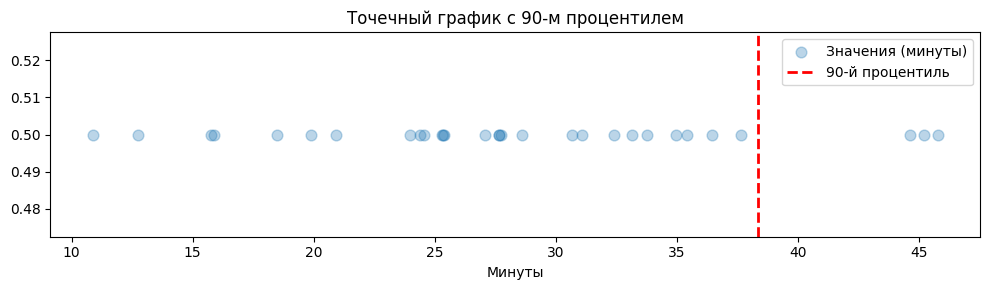

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Генерируем случайные данные
np.random.seed(42)
filtered_df = pd.DataFrame({
    'minutes': np.random.normal(loc=30, scale=10, size=30)  # 30 точек с нормальным распределением
})

# Вычисляем 90-й процентиль
percentile_90 = np.percentile(filtered_df['minutes'], 90)

# Рисуем график
fig, ax1 = plt.subplots(figsize=(10, 3))

# Точечный график: все точки по оси X, а по Y — 0.5
ax1.scatter(filtered_df['minutes'], np.ones(len(filtered_df)) * 0.5, alpha=0.3, s=60, label='Значения (минуты)')

# Вертикальная линия — 90-й процентиль
ax1.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2, label='90-й процентиль')

# Настройки
#ax1.set_yticks([])  # убираем шкалу Y
ax1.set_title('Точечный график с 90-м процентилем')
ax1.set_xlabel('Минуты')
ax1.legend()
plt.tight_layout()
plt.show()
